In [3]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
# Set up visualization function
def custom_draw_geometry(pcd, title="Point Cloud Visualization"):
    """Custom visualization with window title"""
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=title, width=800, height=600)
    vis.add_geometry(pcd)
    vis.get_render_option().background_color = [0.1, 0.1, 0.1]  # Dark background
    vis.get_render_option().point_size = 1.0
    vis.run()
    vis.destroy_window()
    
# 1. Load the PCD file
def load_point_cloud(file_path):
    print(f"Loading point cloud from: {file_path}")
    pcd = o3d.io.read_point_cloud(file_path)
    
    print(f"Point cloud loaded with {len(pcd.points)} points")
    if len(pcd.points) > 0:
        points = np.asarray(pcd.points)
        print(f"X range: {np.min(points[:, 0]):.3f} to {np.max(points[:, 0]):.3f}")
        print(f"Y range: {np.min(points[:, 1]):.3f} to {np.max(points[:, 1]):.3f}")
        print(f"Z range: {np.min(points[:, 2]):.3f} to {np.max(points[:, 2]):.3f}")
    
    # Check if the point cloud has colors
    if pcd.has_colors():
        print("Point cloud has colors")
    else:
        print("Point cloud does not have colors")
    
    # Check if the point cloud has normals
    if pcd.has_normals():
        print("Point cloud has normals")
    else:
        print("Point cloud does not have normals")
    
    return pcd

# Get a list of PCD files in the current directory
pcd_files = glob.glob("*.pcd")

if not pcd_files:
    print("No PCD files found in the current directory")
else:
    print("Available PCD files:")
    for i, file in enumerate(pcd_files):
        print(f"{i}: {file}")
    
    # Choose first PCD file (change index if you want to use another file)
    if pcd_files:
        pcd_path = pcd_files[0]
        pcd = load_point_cloud(pcd_path)
        
        # Visualize the loaded point cloud
        print("Visualizing original point cloud...")
        custom_draw_geometry(pcd, "Original Point Cloud")

Available PCD files:
0: 1603766381849003008.pcd
Loading point cloud from: 1603766381849003008.pcd
Point cloud loaded with 23292 points
X range: -76.955 to 105.229
Y range: -56.421 to 71.694
Z range: -2.599 to 21.911
Point cloud has colors
Point cloud does not have normals
Visualizing original point cloud...


In [5]:
# 2. Pre-processing: Clean the point cloud
def preprocess_point_cloud(pcd, voxel_size=0.05):
    """
    Pre-process the point cloud:
    1. Remove statistical outliers
    2. Downsample with voxel grid
    """
    print("Starting point cloud pre-processing...")
    print(f"Original point cloud has {len(pcd.points)} points")
    
    # Remove outliers with statistical outlier removal
    print("Removing statistical outliers...")
    cl_pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    print(f"After outlier removal: {len(cl_pcd.points)} points")
    
    # Downsample the point cloud with voxel grid
    print(f"Downsampling with voxel size {voxel_size}...")
    down_pcd = cl_pcd.voxel_down_sample(voxel_size)
    print(f"After downsampling: {len(down_pcd.points)} points")
    
    return down_pcd

# 3. Feature extraction: Estimate normals
def extract_features(pcd, radius=0.1, max_nn=30):
    """
    Extract geometric features: surface normals
    """
    print("Estimating point cloud normals...")
    
    # Compute normals with search radius
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=max_nn)
    )
    
    # Orient normals consistently
    pcd.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 100.]))
    
    print("Normal estimation completed")
    
    # Visualize normals
    pcd_with_normals = o3d.geometry.PointCloud(pcd)
    pcd_with_normals.normals = pcd.normals
    
    return pcd_with_normals

# Process the point cloud if it's loaded
if 'pcd' in locals():
    # Pre-process
    processed_pcd = preprocess_point_cloud(pcd, voxel_size=0.05)
    
    # Visualize processed point cloud
    custom_draw_geometry(processed_pcd, "Processed Point Cloud")
    
    # Extract features
    pcd_with_features = extract_features(processed_pcd)
    
    # Visualize point cloud with normals
    print("Visualizing point cloud with normals...")
    o3d.visualization.draw_geometries([pcd_with_features], 
                                     point_show_normal=True,
                                     window_name="Point Cloud with Normals")

Starting point cloud pre-processing...
Original point cloud has 23292 points
Removing statistical outliers...
After outlier removal: 22845 points
Downsampling with voxel size 0.05...
After downsampling: 21058 points
Estimating point cloud normals...
Normal estimation completed
Visualizing point cloud with normals...


Segmenting ground plane...
Plane equation: -0.006x + 0.010y + 1.000z + 2.255 = 0
Angle between plane normal and vertical axis: 0.65 degrees
Ground points: 3264 (15.5%)
Non-ground points: 17794 (84.5%)
Visualizing ground plane segmentation (green = ground, red = non-ground)...
Green = Ground points
Red = Non-ground points


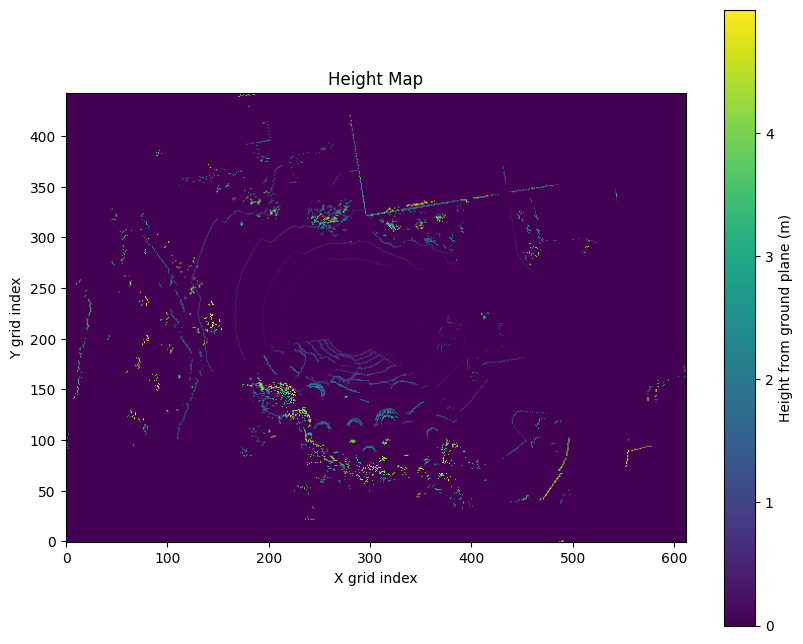

In [ ]:
# 4. Ground plane segmentation using RANSAC
def segment_ground_plane(pcd, distance_threshold=0.05, ransac_n=3, num_iterations=100):
    """
    Segment ground plane using RANSAC
    """
    print("Segmenting ground plane...")
    
    # Apply RANSAC for plane segmentation
    plane_model, inliers = pcd.segment_plane(distance_threshold=distance_threshold,
                                           ransac_n=ransac_n,
                                           num_iterations=num_iterations)
    
    # Get plane equation (ax + by + cz + d = 0)
    [a, b, c, d] = plane_model
    print(f"Plane equation: {a:.3f}x + {b:.3f}y + {c:.3f}z + {d:.3f} = 0")
    
    # Calculate angle of plane normal with vertical axis (z-axis)
    angle = np.arccos(abs(c) / np.sqrt(a**2 + b**2 + c**2)) * 180 / np.pi
    print(f"Angle between plane normal and vertical axis: {angle:.2f} degrees")
    
    # Extract ground and non-ground points
    ground_cloud = pcd.select_by_index(inliers)
    ground_cloud.paint_uniform_color([0.0, 1.0, 0.0])  # Green for ground
    
    non_ground_cloud = pcd.select_by_index(inliers, invert=True)
    non_ground_cloud.paint_uniform_color([1.0, 0.0, 0.0])  # Red for non-ground
    
    print(f"Ground points: {len(ground_cloud.points)} ({len(ground_cloud.points)/len(pcd.points)*100:.1f}%)")
    print(f"Non-ground points: {len(non_ground_cloud.points)} ({len(non_ground_cloud.points)/len(pcd.points)*100:.1f}%)")
    
    return ground_cloud, non_ground_cloud, plane_model

# 5. Visualize segmentation results
def visualize_segmentation(ground_cloud, non_ground_cloud):
    """
    Visualize the segmentation results
    """
    # Create a combined point cloud with different colors
    combined = o3d.geometry.PointCloud()
    combined.points = o3d.utility.Vector3dVector(
        np.vstack([np.asarray(ground_cloud.points), np.asarray(non_ground_cloud.points)])
    )
    combined.colors = o3d.utility.Vector3dVector(
        np.vstack([np.asarray(ground_cloud.colors), np.asarray(non_ground_cloud.colors)])
    )
    
    # Visualize
    print("Visualizing ground plane segmentation (green = ground, red = non-ground)...")
    custom_draw_geometry(combined, "Ground Plane Segmentation")
    
    # Visualize separately
    print("Green = Ground points")
    custom_draw_geometry(ground_cloud, "Ground Points")
    
    print("Red = Non-ground points")
    custom_draw_geometry(non_ground_cloud, "Non-ground Points")

# 6. Height map generation from ground plane
def create_height_map(non_ground_cloud, ground_plane, grid_size=0.2, height_range=(0, 10)):
    """
    Create height map from non-ground points relative to ground plane
    """
    # Extract points
    points = np.asarray(non_ground_cloud.points)
    
    # Get plane equation
    [a, b, c, d] = ground_plane
    
    # Calculate distance of each point to the ground plane (with sign)
    distances = (a * points[:, 0] + b * points[:, 1] + c * points[:, 2] + d) / np.sqrt(a**2 + b**2 + c**2)
    
    # Filter points by height range
    height_mask = (distances >= height_range[0]) & (distances <= height_range[1])
    filtered_points = points[height_mask]
    filtered_heights = distances[height_mask]
    
    # Create 2D grid for height map
    x_min, x_max = np.min(filtered_points[:, 0]), np.max(filtered_points[:, 0])
    y_min, y_max = np.min(filtered_points[:, 1]), np.max(filtered_points[:, 1])
    
    x_grid = np.arange(x_min, x_max, grid_size)
    y_grid = np.arange(y_min, y_max, grid_size)
    
    height_map = np.zeros((len(y_grid), len(x_grid)))
    count_map = np.zeros((len(y_grid), len(x_grid)))
    
    # Assign heights to grid cells
    for i, point in enumerate(filtered_points):
        x_idx = int((point[0] - x_min) / grid_size)
        y_idx = int((point[1] - y_min) / grid_size)
        
        if 0 <= x_idx < len(x_grid) and 0 <= y_idx < len(y_grid):
            height_map[y_idx, x_idx] += filtered_heights[i]
            count_map[y_idx, x_idx] += 1
    
    # Average heights and handle empty cells
    height_map[count_map > 0] = height_map[count_map > 0] / count_map[count_map > 0]
    
    return height_map, (x_min, x_max, y_min, y_max)

# Process if point cloud is available
if 'processed_pcd' in locals():
    # Segment ground plane
    ground_cloud, non_ground_cloud, plane_model = segment_ground_plane(
        processed_pcd, 
        distance_threshold=0.05,
        ransac_n=3,
        num_iterations=1000
    )
    
    # Visualize segmentation results
    visualize_segmentation(ground_cloud, non_ground_cloud)
    
    # Generate height map
    height_map, extents = create_height_map(
        non_ground_cloud, 
        plane_model,
        grid_size=0.2,
        height_range=(0, 5)
    )
    
    # Visualize height map
    plt.figure(figsize=(10, 8))
    plt.imshow(height_map, origin='lower', cmap='viridis')
    plt.colorbar(label='Height from ground plane (m)')
    plt.title('Height Map')
    plt.xlabel('X grid index')
    plt.ylabel('Y grid index')
    plt.show()